In [1]:
import numpy as np
import random
from itertools import combinations
import p2clust
from sklearn import metrics
from experimentacion import Experiments
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pckmeansMonotonic import PCKmeans
import itertools

ModuleNotFoundError: No module named 'scipy'

In [2]:
def generate_data_2D(centers, sigmas, numb_data):  
    np.random.seed(7)
    xpts = np.zeros(1)
    ypts = np.zeros(1)
    labels = np.zeros(1)
    for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
        xpts = np.hstack((xpts, np.random.standard_normal(numb_data) * xsigma + xmu))
        ypts = np.hstack((ypts, np.random.standard_normal(numb_data) * ysigma + ymu))
        labels = np.hstack((labels, np.ones(numb_data) * i))

    X = np.zeros((len(xpts) - 1, 2))
    X[:, 0] = xpts[1:]
    X[:, 1] = ypts[1:]
    
    y = labels[1:]

    return X, y

centers = [(1,5),(1,1),(5,1),(5,5)]
     
sigmas = [(.5,.5),(.5,.5),(.5,.5),(.5,.5)]

X, y = generate_data_2D(centers, sigmas, 100)

In [11]:
Prueba = Experiments(x = X, y = y, nRest = 40) # labeled instances
Prueba.pd_results

COP: K = 4 [x]  -->  DONE
COP-MONO: K = 4 [x]  -->  DONE
P2Clust: K = 4 [x]  -->  DONE
PC: K = 4 [x]  -->  DONE
PC-MONO: K = 4 [x]  -->  DONE


,name,Mutual_info,adjusted_rand_score,unsat,NMI-1,NMI-2
0,COP: K = 4,1.000000,1.000000,0.000000,0.126579,0.7475
1,COP-MONO: K = 4,0.734972,0.660069,0.000000,0.000326,0.0625
2,P2Clust: K = 4,0.790026,0.623941,0.160256,0.000000,0.0000
3,PC: K = 4,1.000000,1.000000,0.000000,0.125702,0.9950
4,PC-MONO: K = 4,0.734647,0.659837,0.000000,0.000301,0.0600


Text(4.9376947829902615, 1.0046461348417954, '3')

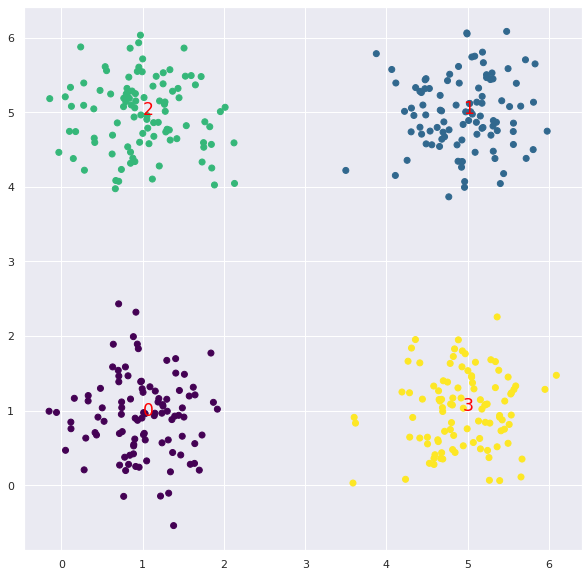

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]
cluster = 0
centroide = Prueba.models[cluster].prototypes

plt.scatter(X[:, 0], X[:, 1], c=Prueba.models[cluster].clusters, cmap='viridis')

plt.text(centroide[0, 0],centroide[0, 1], '0', fontsize = 'x-large', c = 'red')
plt.text(centroide[1, 0],centroide[1, 1], '1', fontsize = 'x-large', c = 'red')
plt.text(centroide[2, 0],centroide[2, 1], '2', fontsize = 'x-large', c = 'red')
plt.text(centroide[3, 0],centroide[3, 1], '3', fontsize = 'x-large', c = 'red')

# Para dibujar las restricciones
#for i in Prueba.ml:
#    plt.plot(X[i, 0], X[i, 1], c='black', linestyle='-')
    
#for i in Prueba.cl:
#    plt.plot(X[i, 0], X[i, 1], c= "black", linestyle=':')

# Implementacion de indices para Monotonia y UNSAT

In [5]:
# Non-Monotonic Index

def NMI1(x: list, clusters: list) -> float:
    """
    Non-Monocity Index (https://sci2s.ugr.es/sites/default/files/1-s2.0-S0169023X16303585-main.pdf)
    
    Numero de instancias no-montónicas dividido entre el total de instancias
    
    :param x: Conjunto de datos.
    :param cluster: Asignacion de cluster a cada instancia.
    :return: nuemro de instancias no-montónicas dividido entre el total de instancias
    """
    nmi = 0
    for i in range(len(x)):
        for j in range(i,len(x)):
            if not isMonotonic(i,j,x, clusters):
                nmi +=2
                
    return nmi/(len(x)*len(x) - len(x))

def NMI2(x: list, clusters: list) -> float:
    """
    Non-Monocity Index (https://sci2s.ugr.es/sites/default/files/1-s2.0-S0169023X16303585-main.pdf)
    
    Numero de instancias no-montónicas dividido entre el total de instancias
    
    :param x: Conjunto de datos.
    :param cluster: Asignacion de cluster a cada instancia.
    :return: nuemro de instancias no-montónicas dividido entre el total de instancias
    """
    nmi = 0
    mon = [True]*len(x)
    
    for i in range(len(x)):
        j = 0
        while mon[i] and j < len(x):
            if not isMonotonic(i,j,x,clusters):
                nmi+=1.0
                mon[i] = False
                if mon[j] != False:
                    nmi+=1.0
                    mon[j] = False
            j+=1
    return nmi/len(x)
    

def isMonotonic(a:int, b:int, x:list, clusters: list) -> bool:
    """
    Compruba si dos instancias (a y b) se pueden comparar
    y en el caso de que lo sea devuelve si la asignación
    de dichas instancias ha sido monotónica (no ha violado 
    la monotonía).
    :param a: Instancia a
    :param b: Instancia b
    :param x: Conjunto de datos.
    :param cluster: Asignacion de cluster a cada instancia.
    :return: Booleano indicando si se viola o no las restricciones de monotonia
    """
    
    state = comparableState(a, b, x)
    if state == '=':
        return clusters[a] == clusters[b]
    elif state == '<':
        return clusters[a] <= clusters[b]
    elif state == '>':
        return clusters[a] >= clusters[b]
    elif state == '<>':
        return True
    
    
    
def comparableState(a:int, b:int, x:list) -> str:
    """
    Funcion que comprueba si dos elementos son comparables y cual es 
    su condicion de comparabilidad (<, >, =, <>)
    :param a: Instancia a
    :param b: Instancia b
    :param x: Conjunto de datos.
    :return: string que indica la relacion que hay entre las instancias a y b
    """
    i = 0
    state = '='
            
    while i < len(x[a]):
        if state == '=':
            if x[a][i] < x[b][i]:
                state = '<'
            elif x[a][i] > x[b][i]:
                state = '>'
            else:
                state = '='
        
        elif state == "<":
            if x[a][i] < x[b][i]:
                state = '<'
            else:
                state = '<>'
                    
        elif state == ">":
            if x[a][i] > x[b][i]:
                state = '>'
            else:
                state = '<>'
        i += 1
    return state

In [13]:
# Unsat

def unsat(cluster: list, ml: list, cl: list) -> float:
    """
    Porcentaje de restricciones violadas.
    
    :param cluster: Asignacion de cluster a cada instancia.
    :param ml: lista de Must Link constrains.
    :param cl: lista de Cannot Link constrains.
    :return: porcentaje de restricciones violadas.
    """
    # Calculamos el número de restricciones ml violadas
    ml_ = [1 if cluster[i] != cluster[j] else 0 for i, j in ml]
    # Calculamos el número de restricciones cl violadas
    cl_ = [1 if cluster[i] == cluster[j] else 0 for i, j in cl]
    # Devolvermos el porcentaje
    return sum(ml_ + cl_)/len(ml+cl)


## Problemas

$\textbf{Problema: }$Asignacion de etiqueta de Cluster a cada Cluster NO ES MONOTONICA, es decir, cuando se generan los clusters se respetan las restricciones de monotonía PERO los clusters no están ordenados (las etiquetas no son monotónicas) con lo que el Non-Monotonic Index da error.

$\textbf{Solucion: }$Renombrar a los clusters basándonos en la distancia euclidea al centroide más pequeño. Ordenamos las etiquetas de los centroides de cada cluster basándonos en la distancia de dicho centroide al punto más pequeño, de forma que las instancias que se encuentran en el cluster con el centroide más cercano al punto más pequeño siempre van a tener etiqueta 0, luego 1 y así.
**Modificacion algoritmo P2CLust propuesto en el primer paper**

$\textbf{Problema: }$ Existe la posibilidad de que las puntuaciones en NMI de los clusters formados por COP y MP kmeans (no monotonicos) sean mejores que las obtenidas por COP y MP kmeans monotinicos, lo cual es un problema. Esto se debe a que si la etiqueta de cluster está ordenada, podemos obtener casos como los que se muestran en el siguiente bloque:

$\textbf{Solucion: }$ Probabilidad de ocurrencia baja, podemos pasar?


Text(4.949688385985993, 4.981812759305755, '3')

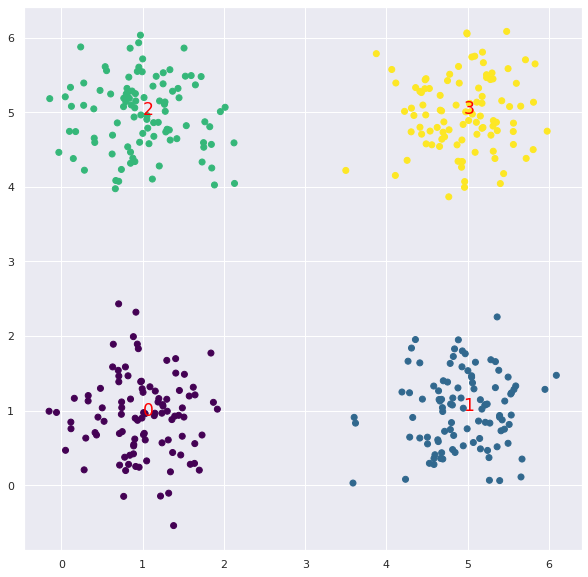

In [7]:
### NO EJECUTAR CELDA, CAMBIA LA IMAGEN.

plt.rcParams['figure.figsize'] = [10, 10]
centroide = Prueba.models[3].prototypes
plt.scatter(X[:, 0], X[:, 1], c=Prueba.models[3].clusters, cmap='viridis')
plt.text(centroide[0, 0],centroide[0, 1], '0', fontsize = 'x-large', c = 'red')
plt.text(centroide[1, 0],centroide[1, 1], '1', fontsize = 'x-large', c = 'red')
plt.text(centroide[2, 0],centroide[2, 1], '2', fontsize = 'x-large', c = 'red')
plt.text(centroide[3, 0],centroide[3, 1], '3', fontsize = 'x-large', c = 'red')


# Comparacion escenarios.

Buscamos demostrar que el clustering monotonico con restricciones es mejor que el clustering monotonico y el clustering con restricciones.

## Caso de estudio 1: 

**Datos monotonicos**

In [72]:
# Datos
centers = [(1,5),(1,1),(5,1),(5,5)]
sigmas = [(.5,.5),(.5,.5),(.5,.5),(.5,.5)]
X, y = generate_data_2D(centers, sigmas, 100)

# Creacion de las etiquetas verdaderas monotonicas:
p2 = p2clust.P2Clust(k = 4)
p2.fit(X)
y = p2.clusters

In [74]:
# Estudio de los diferentes modelos:
Prueba = Experiments(x = X, y = np.array(y), nRest = 40) # labeled instances
Prueba.pd_results

COP: K = 4 [x]  -->  DONE
COP-MONO: K = 4 [x]  -->  DONE
P2Clust: K = 4 [x]  -->  DONE
PC: K = 4 [x]  -->  DONE
PC-MONO: K = 4 [x]  -->  DONE


,name,Mutual_info,adjusted_rand_score,unsat,NMI-1,NMI-2
0,COP: K = 4,0.745383,0.664282,0.00000,0.251917,0.9975
1,COP-MONO: K = 4,0.931723,0.938422,0.00000,0.000000,0.0000
2,P2Clust: K = 4,0.805450,0.647755,0.14359,0.000000,0.0000
3,PC: K = 4,0.743601,0.661084,0.10000,0.319774,1.0000
4,PC-MONO: K = 4,1.000000,1.000000,0.00000,0.000000,0.0000


### Observacion:

Encontramos que con datos monotónicos los algoritmos que incorporan restricciones a la monotonia funcionan incluso mejor que los algoritmos puramente monotonicos y a su vez estos dos funcionan mucho mejor que los algoritmos que no incorporan monotonía.

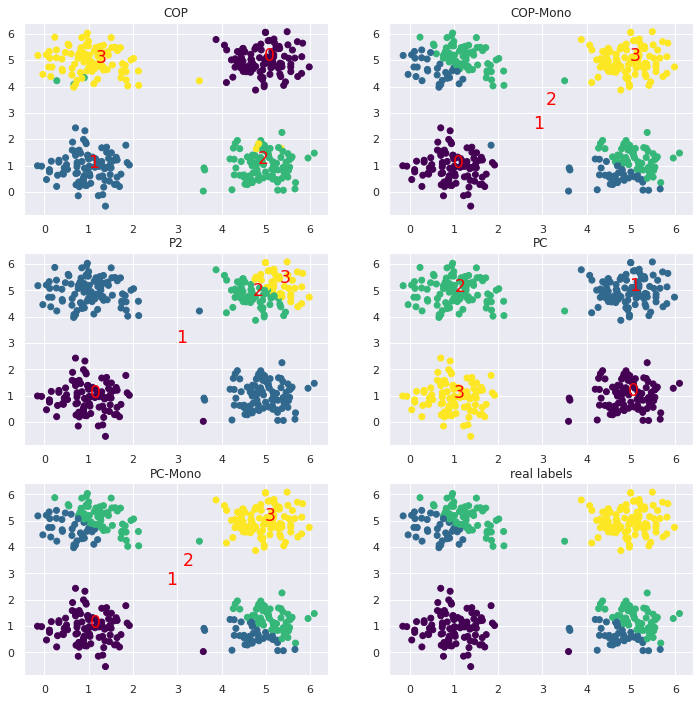

In [81]:
        if self.monotonic:
            self.make_monotonic(prototypes, cluster)
        else:# Observacion de por qué p2 clust nos ha dado datos erroneos

plt.rcParams['figure.figsize'] = [12, 12]

fig, axs = plt.subplots(3,2)

cluster = [0,1,2,3,4,5]
axes = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
titles = ['COP','COP-Mono', 'P2','PC','PC-Mono', 'real labels']

for i,position in zip(cluster, axes):
    if i < 5:
        centroide = Prueba.models[i].prototypes

        axs[tuple(position)].scatter(X[:, 0], X[:, 1], c=Prueba.models[i].clusters, cmap='viridis')

        axs[tuple(position)].text(centroide[0, 0],centroide[0, 1], '0', fontsize = 'x-large', c = 'red')
        axs[tuple(position)].text(centroide[1, 0],centroide[1, 1], '1', fontsize = 'x-large', c = 'red')
        axs[tuple(position)].text(centroide[2, 0],centroide[2, 1], '2', fontsize = 'x-large', c = 'red')
        axs[tuple(position)].text(centroide[3, 0],centroide[3, 1], '3', fontsize = 'x-large', c = 'red')
    
    else:
        axs[tuple(position)].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    
    axs[tuple(position)].set_title(titles[i])


## Caso de estudio 2: 

**Datos No-monotonicos**

### Datos No monotonicos Separados en Cuadrados

In [82]:
# Datos
centers = [(1,5),(1,1),(5,1),(5,5)]
sigmas = [(.5,.5),(.5,.5),(.5,.5),(.5,.5)]
X, y = generate_data_2D(centers, sigmas, 100)

# Estudio de los diferentes modelos:
Prueba = Experiments(x = X, y = np.array(y), nRest = 40) # labeled instances
Prueba.pd_results

COP: K = 4 [x]  -->  DONE
COP-MONO: K = 4 [x]  -->  DONE
P2Clust: K = 4 [x]  -->  DONE
PC: K = 4 [x]  -->  DONE
PC-MONO: K = 4 [x]  -->  DONE


,name,Mutual_info,adjusted_rand_score,unsat,NMI-1,NMI-2
0,COP: K = 4,1.000000,1.000000,0.000000,0.125702,0.9950
1,COP-MONO: K = 4,0.737804,0.665888,0.000000,0.000739,0.1325
2,P2Clust: K = 4,0.779290,0.616887,0.147436,0.000000,0.0000
3,PC: K = 4,1.000000,1.000000,0.000000,0.000000,0.0000
4,PC-MONO: K = 4,0.737271,0.664766,0.000000,0.000777,0.1400


### Observacion:

Encontramos que con datos no monotonicos separados en cuadrados vemos que los que mejor funcionan son los no monotonicos seguidos de los monotonicos con restricciones seguidos de los solo monotonicos

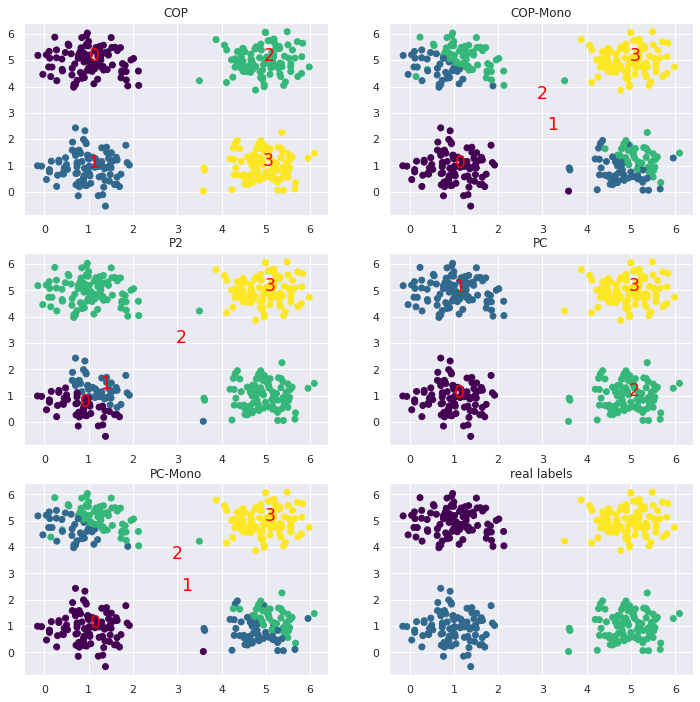

In [83]:
# Observacion de por qué p2 clust nos ha dado datos erroneos

plt.rcParams['figure.figsize'] = [12, 12]

fig, axs = plt.subplots(3,2)

cluster = [0,1,2,3,4,5]
axes = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
titles = ['COP','COP-Mono', 'P2','PC','PC-Mono', 'real labels']

for i,position in zip(cluster, axes):
    if i < 5:
        centroide = Prueba.models[i].prototypes

        axs[tuple(position)].scatter(X[:, 0], X[:, 1], c=Prueba.models[i].clusters, cmap='viridis')

        axs[tuple(position)].text(centroide[0, 0],centroide[0, 1], '0', fontsize = 'x-large', c = 'red')
        axs[tuple(position)].text(centroide[1, 0],centroide[1, 1], '1', fontsize = 'x-large', c = 'red')
        axs[tuple(position)].text(centroide[2, 0],centroide[2, 1], '2', fontsize = 'x-large', c = 'red')
        axs[tuple(position)].text(centroide[3, 0],centroide[3, 1], '3', fontsize = 'x-large', c = 'red')
    
    else:
        axs[tuple(position)].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    
    axs[tuple(position)].set_title(titles[i])


### Datos No monotonicos Separados en Lineas

In [86]:

# Datos
centers = [(1,1),(2,2),(3,3),(4,4)]
sigmas = [(.5,.5),(.5,.5),(.5,.5),(.5,.5)]
X, y = generate_data_2D(centers, sigmas, 100)

# Estudio de los diferentes modelos:
Prueba = Experiments(x = X, y = np.array(y), nRest = 40) # labeled instances
Prueba.pd_results


COP: K = 4 [x]  -->  DONE
COP-MONO: K = 4 [x]  -->  DONE
P2Clust: K = 4 [x]  -->  DONE
PC: K = 4 [x]  -->  DONE
PC-MONO: K = 4 [x]  -->  DONE


,name,Mutual_info,adjusted_rand_score,unsat,NMI-1,NMI-2
0,COP: K = 4,0.734554,0.751687,0.000000,0.357444,1.0000
1,COP-MONO: K = 4,0.749477,0.762394,0.000000,0.000025,0.0075
2,P2Clust: K = 4,0.730765,0.736607,0.089744,0.000000,0.0000
3,PC: K = 4,0.730596,0.746638,0.000000,0.219323,1.0000
4,PC-MONO: K = 4,0.742119,0.756660,0.000000,0.000013,0.0050


### Observacion:

Encontramos que con datos no monotonicos separados en linea los que mejor funcionan son los monotonicos con restricciones seguidos de los no monotonicos y finalmente los solo monotonicos

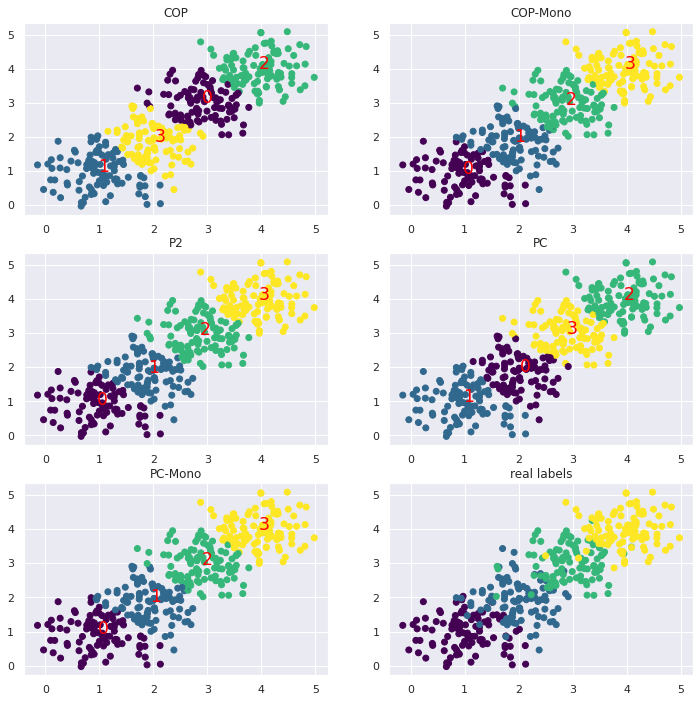

In [87]:
# Observacion de por qué p2 clust nos ha dado datos erroneos

plt.rcParams['figure.figsize'] = [12, 12]

fig, axs = plt.subplots(3,2)

cluster = [0,1,2,3,4,5]
axes = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
titles = ['COP','COP-Mono', 'P2','PC','PC-Mono', 'real labels']

for i,position in zip(cluster, axes):
    if i < 5:
        centroide = Prueba.models[i].prototypes

        axs[tuple(position)].scatter(X[:, 0], X[:, 1], c=Prueba.models[i].clusters, cmap='viridis')

        axs[tuple(position)].text(centroide[0, 0],centroide[0, 1], '0', fontsize = 'x-large', c = 'red')
        axs[tuple(position)].text(centroide[1, 0],centroide[1, 1], '1', fontsize = 'x-large', c = 'red')
        axs[tuple(position)].text(centroide[2, 0],centroide[2, 1], '2', fontsize = 'x-large', c = 'red')
        axs[tuple(position)].text(centroide[3, 0],centroide[3, 1], '3', fontsize = 'x-large', c = 'red')
    
    else:
        axs[tuple(position)].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    
    axs[tuple(position)].set_title(titles[i])
